In [20]:
import pandas as pd

df = pd.read_csv(r'C:\Users\hanvi\Research\melbourne\filtered_data.csv')

df_cleaned = df[['Date', 'Point']]

print(df_cleaned)

# df_cleaned.to_csv('cleaned_data.csv', index=False)

             Date   Point
0      1964-06-17   99.16
1      1964-06-18   84.58
2      1964-06-19   82.16
3      1964-06-20   58.61
4      1964-06-21  185.23
...           ...     ...
21142  2023-12-14   19.46
21143  2023-12-15   15.96
21144  2023-12-16   11.94
21145  2023-12-17   12.18
21146  2023-12-18   12.06

[21147 rows x 2 columns]


In [21]:

df_cleaned = df_cleaned.iloc[:1000]

In [22]:
# Convert 'Date' column to datetime format
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Feature engineering on Date column for discharge forecasting
df_cleaned['Year'] = df_cleaned['Date'].dt.year
df_cleaned['Month'] = df_cleaned['Date'].dt.month
df_cleaned['Day'] = df_cleaned['Date'].dt.day
df_cleaned['DayOfWeek'] = df_cleaned['Date'].dt.dayofweek
df_cleaned['IsWeekend'] = df_cleaned['DayOfWeek'].isin([5, 6]).astype(int)
df_cleaned['DayOfYear'] = df_cleaned['Date'].dt.dayofyear

# Adding lag features for time-series prediction
df_cleaned['Point_Lag1'] = df_cleaned['Point'].shift(1)
df_cleaned['Point_Lag7'] = df_cleaned['Point'].shift(7)
df_cleaned['Point_Lag30'] = df_cleaned['Point'].shift(30)

# Adding rolling statistics
df_cleaned['RollingMean_7'] = df_cleaned['Point'].rolling(window=7).mean()
df_cleaned['RollingMean_30'] = df_cleaned['Point'].rolling(window=30).mean()

In [23]:
df_cleaned = df_cleaned.dropna()


In [24]:
df_cleaned

,Date,Point,Year,Month,Day,DayOfWeek,IsWeekend,DayOfYear,Point_Lag1,Point_Lag7,Point_Lag30,RollingMean_7,RollingMean_30
30,1964-07-17,6597.03,1964,7,17,4,0,199,1496.50,81.29,99.16,1505.057143,504.772000
31,1964-07-18,2149.00,1964,7,18,5,1,200,6597.03,62.86,84.58,1803.077143,573.586000
32,1964-07-19,1732.54,1964,7,19,6,1,201,2149.00,69.08,82.16,2040.714286,628.598667
33,1964-07-20,4157.63,1964,7,20,0,0,202,1732.54,552.70,58.61,2555.704286,765.232667
34,1964-07-21,2463.84,1964,7,21,1,0,203,4157.63,468.90,185.23,2840.695714,841.186333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1967-03-09,1.66,1967,3,9,3,0,68,1.75,1.75,1.56,1.754286,1.608333
996,1967-03-10,1.62,1967,3,10,4,0,69,1.66,1.72,1.36,1.740000,1.617000
997,1967-03-11,1.50,1967,3,11,5,1,70,1.62,1.75,1.26,1.704286,1.625000
998,1967-03-12,1.66,1967,3,12,6,1,71,1.50,1.86,1.42,1.675714,1.633000


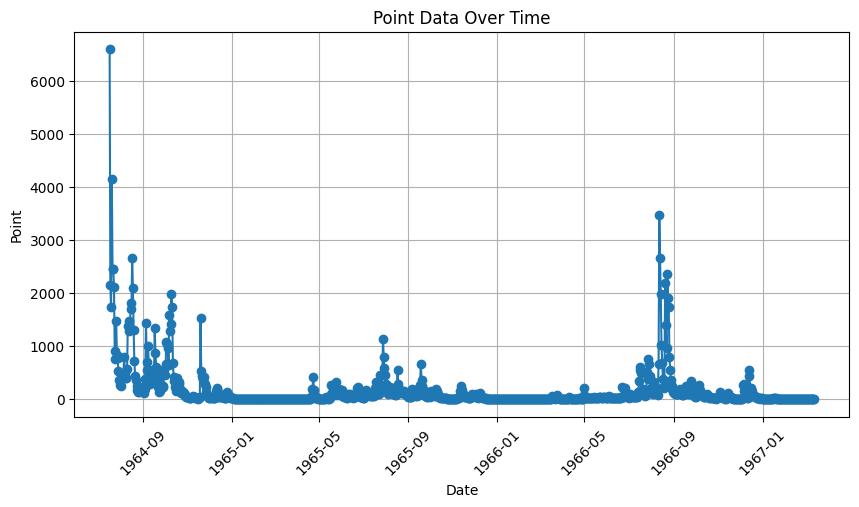

In [25]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.plot(df_cleaned['Date'], df_cleaned['Point'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Point')
plt.title('Point Data Over Time')
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_cleaned.drop(columns=['Date']))

# Split data into training and test sets
train_data, test_data = train_test_split(df_scaled, test_size=0.2, shuffle=False)

In [28]:

# Create dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length=30):
        self.data = data
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length, :-1]
        y = self.data[index + self.seq_length, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Create data loaders
seq_length = 30
train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [29]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

# Initialize model
input_size = train_data.shape[1] - 1
model = LSTMModel(input_size=input_size, hidden_size=64, num_layers=2, output_size=1)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [30]:
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')


In [31]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
    print(f'Test Loss: {total_loss/len(test_loader):.4f}')



In [32]:
train_model(model, train_loader, criterion, optimizer, epochs=20)


Epoch 1, Loss: 0.0226
Epoch 2, Loss: 0.0117
Epoch 3, Loss: 0.0092
Epoch 4, Loss: 0.0034
Epoch 5, Loss: 0.0021
Epoch 6, Loss: 0.0012
Epoch 7, Loss: 0.0010
Epoch 8, Loss: 0.0007
Epoch 9, Loss: 0.0010
Epoch 10, Loss: 0.0011
Epoch 11, Loss: 0.0005
Epoch 12, Loss: 0.0005
Epoch 13, Loss: 0.0006
Epoch 14, Loss: 0.0004
Epoch 15, Loss: 0.0004
Epoch 16, Loss: 0.0003
Epoch 17, Loss: 0.0004
Epoch 18, Loss: 0.0007
Epoch 19, Loss: 0.0005
Epoch 20, Loss: 0.0003


In [33]:
evaluate_model(model, test_loader, criterion)


Test Loss: 0.0001
